## Imports

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly import express as px, graph_objects as go
from plotly.subplots import make_subplots

# import seaborn as sns

# ignore warnings when graphs are plotted
import warnings

warnings.filterwarnings("ignore")

## Read data

In [45]:
# Read csv files
data = pd.read_csv("../data/train.csv", index_col=0).reset_index(drop=True)

# Transform city names to english format
cities_rus_to_eng = {
    "Москва": "Moscow",
    "Санкт-Петербург": "St.Petersburg",
    "Краснодар": "Krasnodar",
    "Самара": "Samara",
    "Нижний Новгород": "Nizhny.Novgorod",
    "Ростов-на-Дону": "Rostov-on-Don",
    "Волгоград": "Volgograd",
    "Воронеж": "Voronezh",
    "Казань": "Kazan",
    "Екатеринбург": "Yekaterinburg",
}
data = data.replace(cities_rus_to_eng)

# Transform weather description to english format
weather_rus_to_eng = {
    "переменная облачность, небольшой дождь": "partly cloudy, light rain",
    "переменная облачность": "partly cloudy",
    "облачно, небольшой дождь": "cloudy, light rain",
    "дождь, гроза": "rain, thunderstorm",
    "облачно, без существенных осадков": "cloudy, no significant precipitation",
    "переменная облачность, дождь": "partly cloudy, rain",
    "дождь": "rain",
    "облачно": "cloudy",
    "ясно": "clear",
    "облачно, небольшой снег": "cloudy, light snow",
    "переменная облачность, небольшие осадки": "partly cloudy, light precipitation",
    "облачно, небольшие осадки": "cloudy, slight precipitation",
    "снег": "snow",
    "метель": "blizzard",
    "осадки": "rainfall",
    "переменная облачность, небольшой снег": "partly cloudy, light snow",
}
data = data.replace(weather_rus_to_eng)

In [46]:
# check data sample
data.head()

date city_name  store_id  category_id  product_id  price  \
0  2021-07-29    Moscow         1            1           1   4.79   
1  2021-07-30    Moscow         1            1           1   4.79   
2  2021-07-31    Moscow         1            1           1   4.79   
3  2021-08-01    Moscow         1            1           1   4.79   
4  2021-08-02    Moscow         1            1           1   4.79   

                weather_desc  humidity  temperature  pressure  sales  
0  partly cloudy, light rain   61.9375      23.1875  741.0000     26  
1  partly cloudy, light rain   70.2500      22.1875  740.3125     37  
2              partly cloudy   52.6250      21.8125  741.6250     25  
3         cloudy, light rain   87.4375      20.0625  743.3125     26  
4              partly cloudy   66.1875      23.4375  739.6250     22

In [47]:
# check shape of dfs
print(f"data shape: {data.shape}")

data shape: (666676, 11)


In [48]:
# check data periods
print(f"Data period:\tfrom {data.date.min()} to {data.date.max()}")

Data period:	from 2021-07-29 to 2022-02-13


Table of variables
- date - Transaction date

-	city_name	- Name of the city where the sale took place
-	store_id	- Unique identifier for each store
-	category_id	- Product category
-	product_id	- Unique identifier for each type of product
-	price	- Price of the product
-	weather_desc	- Weather description
-	humidity	- Humidity in the city on the day of sale
-	temperature	- Temperature in the city on the day of sale
-	pressure	- Atmosphere pressure in the city on the day of sale
-	sales	- Number of product sales (Target column)

## Exploratory Data Analysis

### Statistical data description

Two dataframes (train.csv and test.csv) have common list of 11 variables. "Sales" variable is present only in train dataframe.  <br>

In [49]:
# column names and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666676 entries, 0 to 666675
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   date          666676 non-null  object 
 1   city_name     666676 non-null  object 
 2   store_id      666676 non-null  int64  
 3   category_id   666676 non-null  int64  
 4   product_id    666676 non-null  int64  
 5   price         666676 non-null  float64
 6   weather_desc  666676 non-null  object 
 7   humidity      666676 non-null  float64
 8   temperature   666676 non-null  float64
 9   pressure      666676 non-null  float64
 10  sales         666676 non-null  int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 55.9+ MB


In [50]:
# get categorical columns
cat_cols = [col for col in data.columns if data[col].unique().shape[0] < 20]
print("Categorical columns:", cat_cols)

# get continuous columns
cont_cols = list(
    set(data.select_dtypes(include="number").columns)
    - set(cat_cols)
    - set(["id", "product_id", "store_id"])  # non-decriptive
)
print("Continuous columns:", cont_cols)

Categorical columns: ['city_name', 'category_id', 'weather_desc']
Continuous columns: ['temperature', 'price', 'humidity', 'sales', 'pressure']


In [51]:
# correlation of continuous cols with target col
pd.DataFrame(data[cont_cols].corr().loc["sales"].sort_values())
# in cat cols - no order -> no meaningful tests

sales
price       -0.187137
temperature -0.072724
pressure    -0.056915
humidity     0.129832
sales        1.000000


There are 666 676 observations in the train dataframe and 24 836 observations in the test dataframe.  <br>
The train dataframe describes data in 7 months period, from June 29, 2021 to February 13, 2022. <br>
The test dataframe describes data in one week period from February 14, 2022 to February 20, 2022.  <br>
The dataframe contains information from 10 cities:  
Moscow, 	St. Petersburg, Krasnodar,	Samara, Nizhny Novgorod	Rostov-on-Don, Volgograd,	Voronezh, Kazan, and	Yekaterinburg.

In [52]:
# the code is represented in the table below
data.describe().round(1)

store_id  category_id  product_id     price  humidity  temperature  \
count  666676.0     666676.0    666676.0  666676.0  666676.0     666676.0   
mean       76.5          2.4        17.9       5.1      74.3          4.9   
std        44.6          1.9        10.8       3.4      20.4         11.6   
min         1.0          1.0         1.0       1.9      13.8        -24.0   
25%        39.0          1.0         9.0       3.0      59.8         -3.3   
50%        75.0          1.0        17.0       4.1      79.7          4.4   
75%       115.0          4.0        29.0       6.0      92.4         11.8   
max       164.0          9.0        35.0      18.6     100.0         34.2   

       pressure     sales  
count  666676.0  666676.0  
mean      750.9      10.1  
std        10.0      15.1  
min       710.0       0.0  
25%       744.7       2.0  
50%       750.7       5.0  
75%       757.7      12.0  
max       779.0     275.0

In [53]:
x = data[["store_id", "product_id", "sales", "date"]].copy()
for i in [7, 14, 21]:
    x[f"sales_lag_{int(i/7)}_week"] = x.groupby(
        [
            "store_id",
            "product_id",
        ],
        as_index=False,
    )["sales"].shift(i)

pd.DataFrame(
    x[["sales", "sales_lag_1_week", "sales_lag_2_week", "sales_lag_3_week"]].corr()[
        "sales"
    ]
)

sales
sales             1.000000
sales_lag_1_week  0.858010
sales_lag_2_week  0.852436
sales_lag_3_week  0.840912

### Data visualisation

-  the number of sales noticably changes throughout the week in each city. 
- In different cities there is a different rate of sales.
- The noticeable sharp decrease in sales can be observed around holidays 
- The tendency can be noticed that the total number of sales is started to rise in the winter.

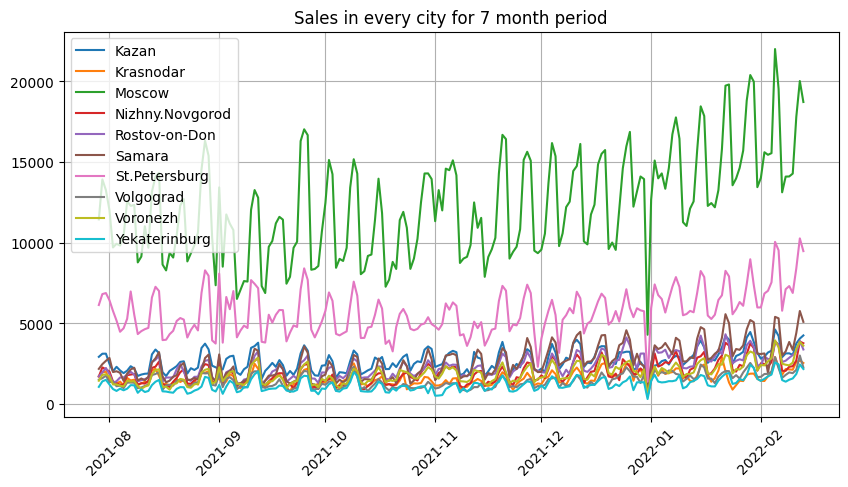

In [54]:
cities = data_by_city["city_name"].unique().tolist()
plt.figure(figsize=(10, 5))

for city in cities:
    sample = data_by_city[data_by_city["city_name"] == city]

    plt.plot(pd.to_datetime(sample["date"]), sample["sales"], label=city)

plt.legend()
plt.title("Sales in every city for 7 month period")
plt.xticks(rotation=45)
plt.grid()
plt.show()

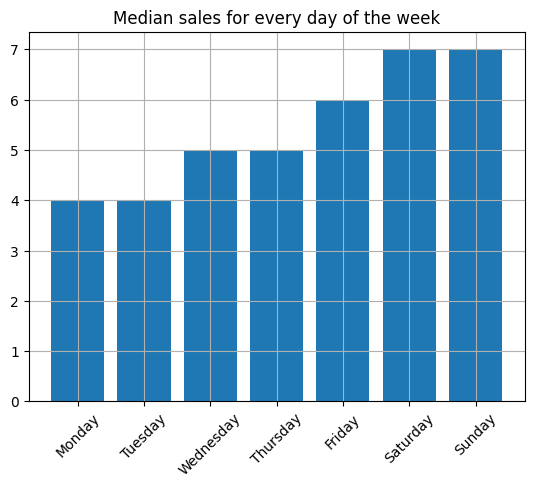

In [60]:
weekdays = data[["date", "sales"]]
weekdays.date = pd.to_datetime(weekdays.date)
weekdays = weekdays.groupby([weekdays.date.dt.weekday], as_index=False).median()
weekdays["weekdays"] = (
    pd.to_datetime(data.iloc[4:].date).dt.strftime("%A").unique()
)  # add weekdays from monday to sunday

plt.bar(weekdays["weekdays"], weekdays["sales"])
plt.xticks(rotation=45)
plt.title("Median sales for every day of the week")
plt.grid()
plt.show()

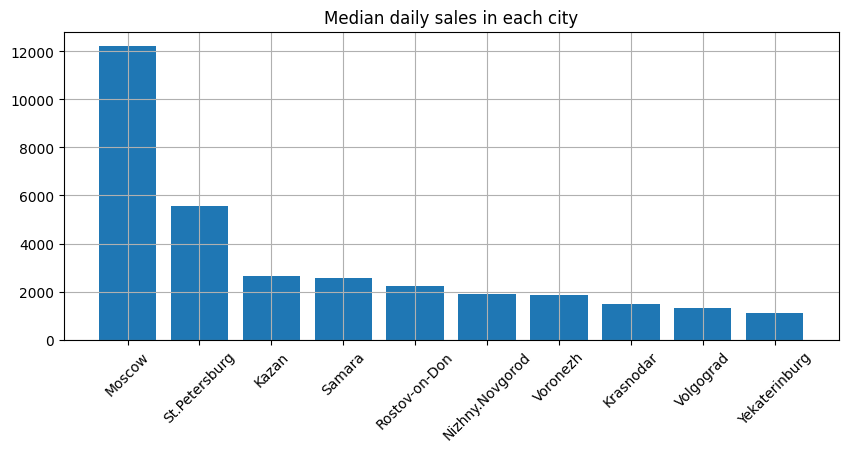

In [77]:
daily = data[["city_name", "sales", "date"]]
daily.date = pd.to_datetime(daily.date)
daily = daily.replace(
    (
        "Moscow",
        "St.Petersburg",
        "Krasnodar",
        "Samara",
        "Nizhny.Novgorod",
        "Rostov-on-Don",
        "Volgograd",
        "Voronezh",
        "Kazan",
        "Yekaterinburg",
    ),
    (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
)
daily.city_name = daily.city_name.astype("int")
daily = daily.groupby([daily.city_name, daily.date], as_index=False).sum()
daily = daily.groupby([daily.city_name], as_index=False).median()
daily.sort_values("sales", ascending=False, inplace=True)
daily = daily.replace(
    (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
    (
        "Moscow",
        "St.Petersburg",
        "Krasnodar",
        "Samara",
        "Nizhny.Novgorod",
        "Rostov-on-Don",
        "Volgograd",
        "Voronezh",
        "Kazan",
        "Yekaterinburg",
    ),
)

plt.figure(figsize=(10, 4))
plt.bar(daily["city_name"], daily["sales"])
plt.xticks(rotation=45)
plt.title("Median daily sales in each city")
plt.grid()
plt.show()

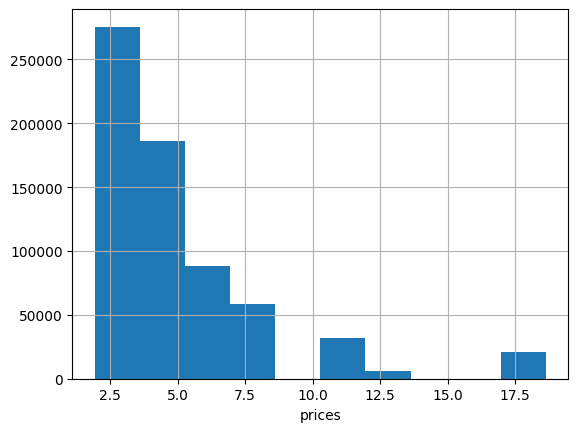

In [75]:
plt.hist(data["price"], bins=10)
plt.xlabel("prices")
plt.grid()

In [69]:
# import plotly.express as px
# df = px.data.tips()
# prices
fig = px.histogram(
    data[["price", "sales"]],
    x="price",
    nbins=20,
)

# modify layout of the graph
fig.update_layout(
    height=400,
    title={
        "text": "Prices histogram",
        "y": 0.97,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    width=600,
    yaxis_title="Sales",
    xaxis_title="Price",
    showlegend=False,
    margin=dict(l=40, r=10, t=30, b=60),
)

fig.show()

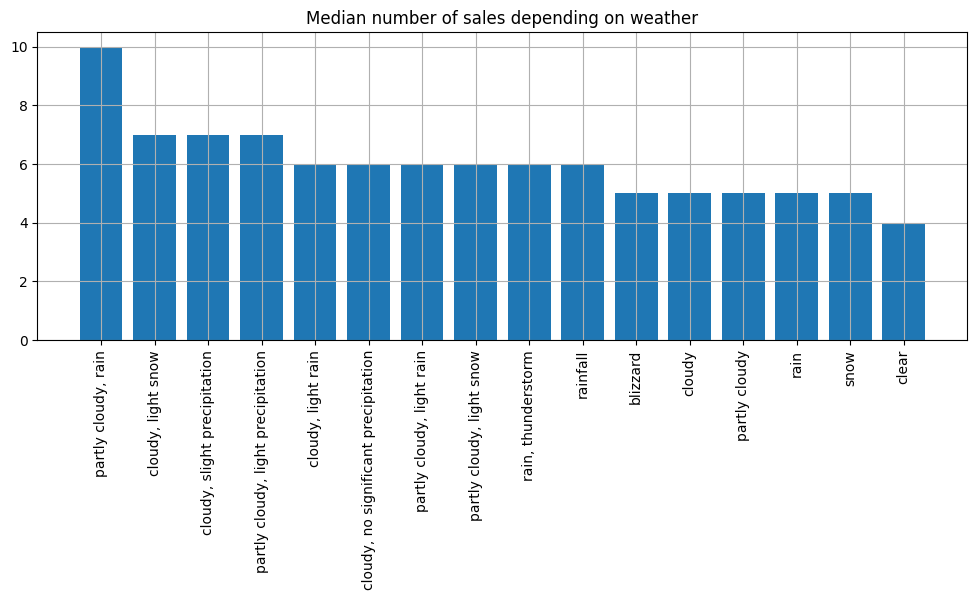

In [85]:
# subset data for plot "Median number of sales depending on weather"
median_weather = data[["weather_desc", "sales"]]

median_weather = median_weather.groupby(
    [median_weather.weather_desc], as_index=False
).median()
median_weather.sort_values("sales", ascending=False, inplace=True)

plt.figure(figsize=(12, 4))
plt.bar(median_weather["weather_desc"], median_weather["sales"])
plt.xticks(rotation=90)
plt.title("Median number of sales depending on weather")
plt.grid()
plt.show()

Lag features show high correlation with the number of sales and should significantly improve predictions of future sales.

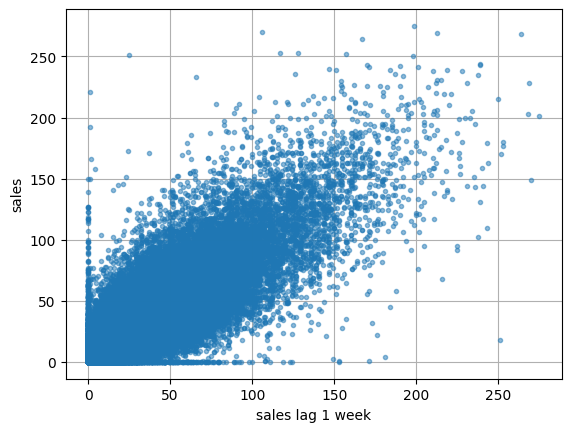

In [90]:
x = data[["store_id", "product_id", "sales", "date"]].copy()
for i in [7, 14, 21]:
    x[f"sales_lag_{int(i/7)}_week"] = x.groupby(
        [
            "store_id",
            "product_id",
        ],
        as_index=False,
    )["sales"].shift(i)

plt.plot(x["sales_lag_1_week"], x["sales"], ".", alpha=0.5)
plt.xlabel("sales lag 1 week")
plt.ylabel("sales")
plt.grid()

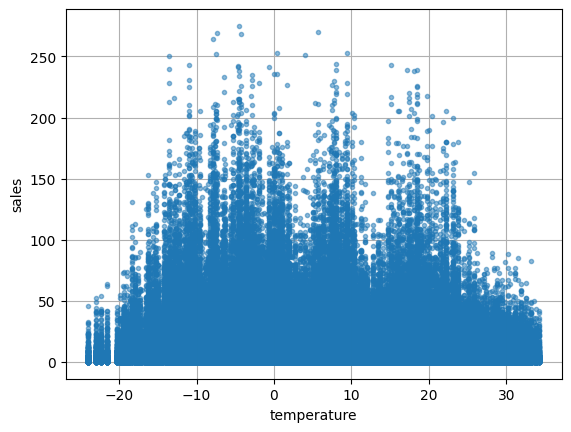

In [93]:
plt.plot(data["temperature"], data["sales"], ".", alpha=0.5)
plt.xlabel("temperature")
plt.ylabel("sales")
plt.grid()

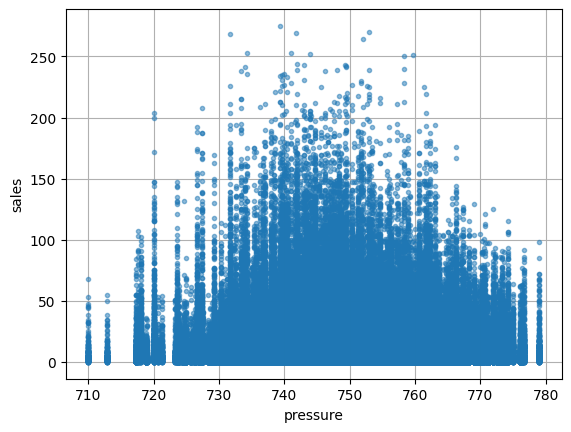

In [95]:
plt.plot(data["pressure"], data["sales"], ".", alpha=0.5)
plt.xlabel("pressure")
plt.ylabel("sales")
plt.grid()

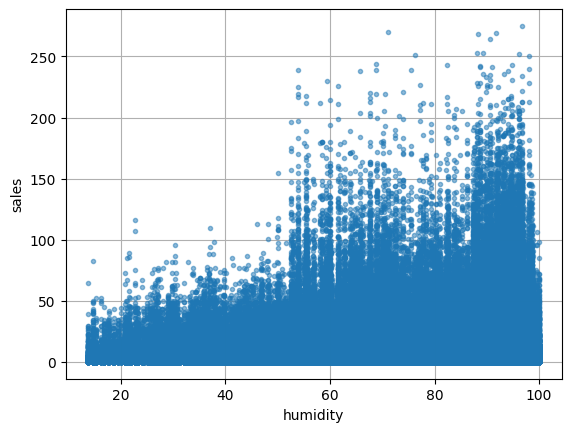

In [97]:
plt.plot(data["humidity"], data["sales"], ".", alpha=0.5)
plt.xlabel("humidity")
plt.ylabel("sales")
plt.grid()